In [1]:
## Set-up (패키지 import, 변수 생성)

import os, re
import random, math
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Add
from tensorflow.keras.models import Model
import cv2
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 5

print(ROOT_PATH)

/aiffel/aiffel


In [2]:
## 데이터 가져오기
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)


5216
624
16
4185
1047
Normal image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person162_virus_321.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg
Normal images count in training set: 1082
Pneumonia images count in training set: 3103
Training images count: 4185
Validating images count: 1047
Image shape:  (180, 180, 3)
Label:  True
624


In [3]:
## 데이터 증강1 (확대) - 좌우반전보다는 확대하는게 더 의미가 있을 것 같아서 진행
def augment1(image,label):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.central_crop(image, central_fraction=0.95)
        image = tf.image.resize(image, (180,180))  # 랜덤하게 확대
    return image,label

## 데이터 증강2 (기존, 좌우반전)
def augment2(image, label):
    image = tf.image.random_flip_left_right(image) # 랜덤하게 좌우를 반전합니다.
    return image,label

## 데이터 증강3 (좌우반전 + 확대)
def augment3(image, label):
    image = tf.image.random_flip_left_right(image)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.central_crop(image, central_fraction=0.95)
        image = tf.image.resize(image, (180,180))  # 랜덤하게 확대
    return image,label



In [4]:
def prepare_for_training1(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds1 = ds.map(
            augment1,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds1 = ds1.shuffle(buffer_size=shuffle_buffer_size)
    ds1 = ds1.repeat()
    ds1 = ds1.batch(BATCH_SIZE)
    ds1 = ds1.prefetch(buffer_size=AUTOTUNE)

    return ds1

train_ds1 = prepare_for_training1(train_ds)
val_ds1 = prepare_for_training1(val_ds)

def prepare_for_training2(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds2 = ds.map(
            augment2,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds2 = ds2.shuffle(buffer_size=shuffle_buffer_size)
    ds2 = ds2.repeat()
    ds2 = ds2.batch(BATCH_SIZE)
    ds2 = ds2.prefetch(buffer_size=AUTOTUNE)

    return ds2

train_ds2 = prepare_for_training2(train_ds)
val_ds2 = prepare_for_training2(val_ds)

def prepare_for_training3(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds3 = ds.map(
            augment3,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds3 = ds3.shuffle(buffer_size=shuffle_buffer_size)
    ds3 = ds3.repeat()
    ds3 = ds3.batch(BATCH_SIZE)
    ds3 = ds3.prefetch(buffer_size=AUTOTUNE)

    return ds3

train_ds3 = prepare_for_training3(train_ds)
val_ds3 = prepare_for_training3(val_ds)

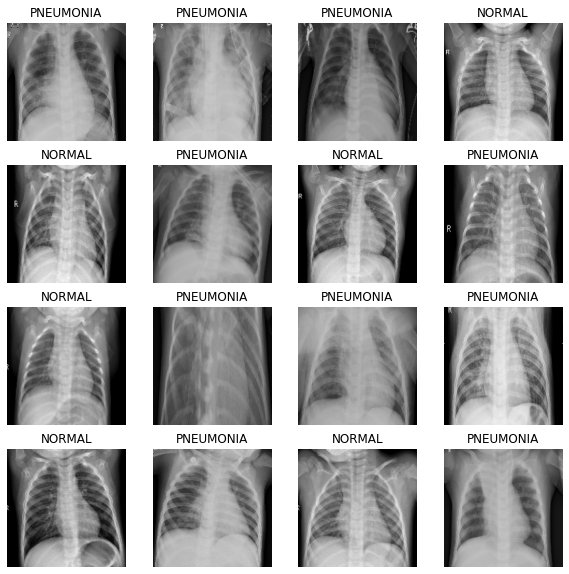

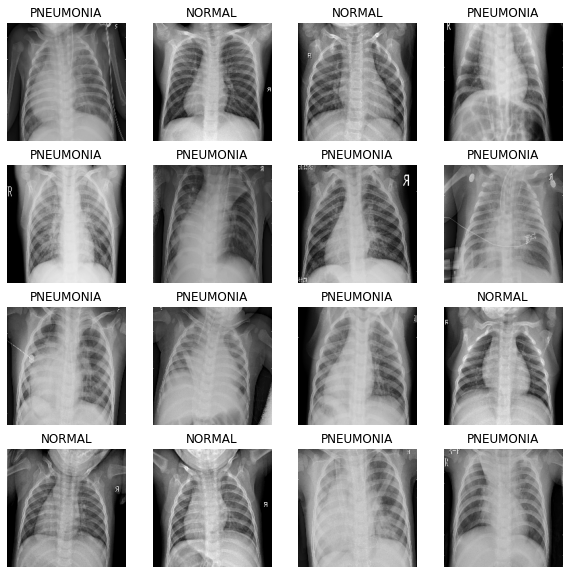

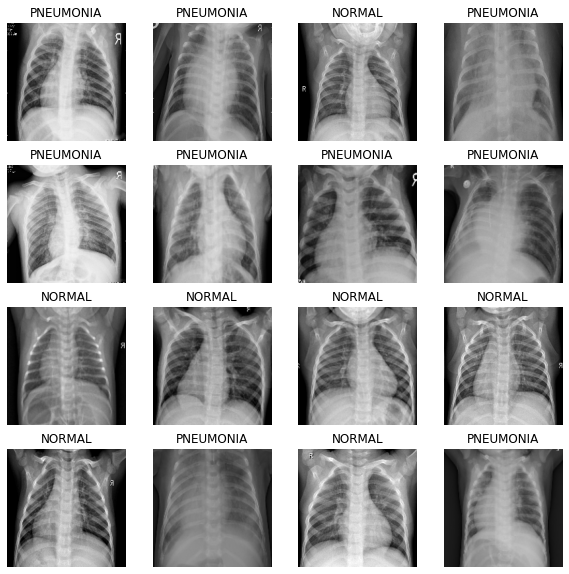

In [5]:
## 데이터 시각화
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds1))
show_batch(image_batch.numpy(), label_batch.numpy())

image_batch, label_batch = next(iter(train_ds2))
show_batch(image_batch.numpy(), label_batch.numpy())

image_batch, label_batch = next(iter(train_ds3))
show_batch(image_batch.numpy(), label_batch.numpy())

In [6]:
## CNN 모델링
#기존 노드 모델
    # Convolution block 만들기
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

    # Dense Block 만들기
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model1():
    model1 = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model1

def build_model2():
    model2 = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model2

def build_model3():
    model3 = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model3

In [7]:
## Resnet18 구현
def residual_block(x, filters, stride=1, projection=False):
    shortcut = x
    x = Conv2D(filters, (3, 3), strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    if projection:
        shortcut = Conv2D(filters, (1, 1), strides=stride)(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

def build_resnet18(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    x = Conv2D(64, (7, 7), strides=2, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 128, stride=2, projection=True)
    x = residual_block(x, 128)
    x = residual_block(x, 256, stride=2, projection=True)
    x = residual_block(x, 256)
    x = residual_block(x, 512, stride=2, projection=True)
    x = residual_block(x, 512)

    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=x)

    return model

input_shape = (180, 180, 3)  # 입력 이미지 크기 및 채널 수에 맞게 설정
num_classes = 2  # 분류할 클래스 수에 맞게 설정

model = build_resnet18(input_shape, num_classes)

In [8]:
# 클래스 불균형 관련
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.93
Weight for PNEUMONIA: 0.67


In [9]:
### CNN 모델
with tf.device('/GPU:0'):
    model1 = build_model1()
    model2 = build_model2()
    model3 = build_model3()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model1.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    model2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    model3.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [10]:
with tf.device('/GPU:0'):
    history1 = model1.fit(
        train_ds1,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds1,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/5
261/261 [==============================] - 107s 206ms/step - loss: 0.4650 - accuracy: 0.7526 - precision: 0.9425 - recall: 0.7097 - val_loss: 0.5736 - val_accuracy: 0.7452 - val_precision: 0.7452 - val_recall: 1.0000
Epoch 2/5
261/261 [==============================] - 53s 204ms/step - loss: 0.2432 - accuracy: 0.9028 - precision: 0.9729 - recall: 0.8937 - val_loss: 1.1200 - val_accuracy: 0.7452 - val_precision: 0.7452 - val_recall: 1.0000
Epoch 3/5
261/261 [==============================] - 54s 206ms/step - loss: 0.2040 - accuracy: 0.9224 - precision: 0.9757 - recall: 0.9183 - val_loss: 0.7358 - val_accuracy: 0.7615 - val_precision: 0.7571 - val_recall: 1.0000
Epoch 4/5
261/261 [==============================] - 54s 206ms/step - loss: 0.1873 - accuracy: 0.9274 - precision: 0.9784 - recall: 0.9225 - val_loss: 0.1279 - val_accuracy: 0.9490 - val_precision: 0.9423 - val_recall: 0.9922
Epoch 5/5
261/261 [==============================] - 54s 209ms/step - loss: 0.1743 - accuracy: 

In [11]:
with tf.device('/GPU:0'):
    history2 = model2.fit(
        train_ds2,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds2,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/5
261/261 [==============================] - 61s 198ms/step - loss: 0.4234 - accuracy: 0.8029 - precision: 0.9514 - recall: 0.8189 - val_loss: 0.5896 - val_accuracy: 0.7452 - val_precision: 0.7452 - val_recall: 1.0000
Epoch 2/5
261/261 [==============================] - 51s 196ms/step - loss: 0.2473 - accuracy: 0.9037 - precision: 0.9746 - recall: 0.8934 - val_loss: 1.0348 - val_accuracy: 0.7442 - val_precision: 0.7442 - val_recall: 1.0000
Epoch 3/5
261/261 [==============================] - 53s 203ms/step - loss: 0.2196 - accuracy: 0.9148 - precision: 0.9721 - recall: 0.9112 - val_loss: 0.5599 - val_accuracy: 0.7990 - val_precision: 0.7874 - val_recall: 1.0000
Epoch 4/5
261/261 [==============================] - 52s 201ms/step - loss: 0.2056 - accuracy: 0.9262 - precision: 0.9738 - recall: 0.9254 - val_loss: 0.1474 - val_accuracy: 0.9481 - val_precision: 0.9931 - val_recall: 0.9366
Epoch 5/5
261/261 [==============================] - 53s 205ms/step - loss: 0.1718 - accuracy: 0

In [12]:
with tf.device('/GPU:0'):
    history3 = model3.fit(
        train_ds3,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds3,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/5
261/261 [==============================] - 62s 202ms/step - loss: 0.4416 - accuracy: 0.8106 - precision: 0.9540 - recall: 0.8043 - val_loss: 0.6011 - val_accuracy: 0.7452 - val_precision: 0.7452 - val_recall: 1.0000
Epoch 2/5
261/261 [==============================] - 52s 200ms/step - loss: 0.2808 - accuracy: 0.8839 - precision: 0.9631 - recall: 0.8769 - val_loss: 1.1344 - val_accuracy: 0.7442 - val_precision: 0.7442 - val_recall: 1.0000
Epoch 3/5
261/261 [==============================] - 52s 202ms/step - loss: 0.2624 - accuracy: 0.8934 - precision: 0.9630 - recall: 0.8906 - val_loss: 0.3078 - val_accuracy: 0.8404 - val_precision: 0.8238 - val_recall: 1.0000
Epoch 4/5
261/261 [==============================] - 53s 205ms/step - loss: 0.2178 - accuracy: 0.9133 - precision: 0.9717 - recall: 0.9094 - val_loss: 0.2421 - val_accuracy: 0.8981 - val_precision: 0.9985 - val_recall: 0.8645
Epoch 5/5
261/261 [==============================] - 54s 209ms/step - loss: 0.1848 - accuracy: 0

In [13]:
## Resnet 모델
with tf.device('/GPU:0'):
    input_shape = (180, 180, 3)  # 입력 이미지 크기 및 채널 수에 맞게 설정
    num_classes = 2
    
    model4 = build_resnet18(input_shape, num_classes)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model4.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
    history4 = model4.fit(
        train_ds1,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds1,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/5
261/261 [==============================] - 63s 198ms/step - loss: 0.3194 - accuracy: 0.7416 - precision: 0.7416 - recall: 1.0000 - val_loss: 0.3927 - val_accuracy: 0.7442 - val_precision: 0.7442 - val_recall: 1.0000
Epoch 2/5
261/261 [==============================] - 51s 197ms/step - loss: 0.1480 - accuracy: 0.7416 - precision: 0.7416 - recall: 1.0000 - val_loss: 0.0701 - val_accuracy: 0.7442 - val_precision: 0.7442 - val_recall: 1.0000
Epoch 3/5
261/261 [==============================] - 52s 199ms/step - loss: 0.1286 - accuracy: 0.7411 - precision: 0.7411 - recall: 1.0000 - val_loss: 1.0624 - val_accuracy: 0.7442 - val_precision: 0.7442 - val_recall: 1.0000
Epoch 4/5
261/261 [==============================] - 53s 205ms/step - loss: 0.1038 - accuracy: 0.7411 - precision: 0.7411 - recall: 1.0000 - val_loss: 0.2791 - val_accuracy: 0.7442 - val_precision: 0.7442 - val_recall: 1.0000
Epoch 5/5
261/261 [==============================] - 55s 212ms/step - loss: 0.0942 - accuracy: 0

In [14]:
## Resnet 모델
with tf.device('/GPU:0'):
    input_shape = (180, 180, 3)  # 입력 이미지 크기 및 채널 수에 맞게 설정
    num_classes = 2
    
    model5 = build_resnet18(input_shape, num_classes)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model5.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
    history5 = model5.fit(
        train_ds2,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds2,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/5
261/261 [==============================] - 61s 198ms/step - loss: 0.2992 - accuracy: 0.7414 - precision: 0.7414 - recall: 1.0000 - val_loss: 3.2118 - val_accuracy: 0.7452 - val_precision: 0.7452 - val_recall: 1.0000
Epoch 2/5
261/261 [==============================] - 51s 196ms/step - loss: 0.1951 - accuracy: 0.7407 - precision: 0.7407 - recall: 1.0000 - val_loss: 10.6627 - val_accuracy: 0.7452 - val_precision: 0.7452 - val_recall: 1.0000
Epoch 3/5
261/261 [==============================] - 51s 198ms/step - loss: 0.1488 - accuracy: 0.7423 - precision: 0.7423 - recall: 1.0000 - val_loss: 21.6615 - val_accuracy: 0.7452 - val_precision: 0.7452 - val_recall: 1.0000
Epoch 4/5
261/261 [==============================] - 53s 202ms/step - loss: 0.1497 - accuracy: 0.7411 - precision: 0.7411 - recall: 1.0000 - val_loss: 0.5213 - val_accuracy: 0.7462 - val_precision: 0.7462 - val_recall: 1.0000
Epoch 5/5
261/261 [==============================] - 53s 203ms/step - loss: 0.1066 - accuracy:

In [15]:
## Resnet 모델
with tf.device('/GPU:0'):
    input_shape = (180, 180, 3)  # 입력 이미지 크기 및 채널 수에 맞게 설정
    num_classes = 2
    
    model6 = build_resnet18(input_shape, num_classes)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model6.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
    history6 = model6.fit(
        train_ds3,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds3,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/5
261/261 [==============================] - 61s 197ms/step - loss: 0.3650 - accuracy: 0.7414 - precision: 0.7414 - recall: 1.0000 - val_loss: 4.2403 - val_accuracy: 0.7452 - val_precision: 0.7452 - val_recall: 1.0000
Epoch 2/5
261/261 [==============================] - 52s 198ms/step - loss: 0.2160 - accuracy: 0.7411 - precision: 0.7411 - recall: 1.0000 - val_loss: 0.2140 - val_accuracy: 0.7442 - val_precision: 0.7442 - val_recall: 1.0000
Epoch 3/5
261/261 [==============================] - 52s 198ms/step - loss: 0.1581 - accuracy: 0.7416 - precision: 0.7416 - recall: 1.0000 - val_loss: 1.7602 - val_accuracy: 0.7452 - val_precision: 0.7452 - val_recall: 1.0000
Epoch 4/5
261/261 [==============================] - 52s 201ms/step - loss: 0.1545 - accuracy: 0.7416 - precision: 0.7416 - recall: 1.0000 - val_loss: 0.9031 - val_accuracy: 0.7462 - val_precision: 0.7462 - val_recall: 1.0000
Epoch 5/5
261/261 [==============================] - 54s 207ms/step - loss: 0.1238 - accuracy: 0

Text(0.5, 0.98, 'CNN Model')

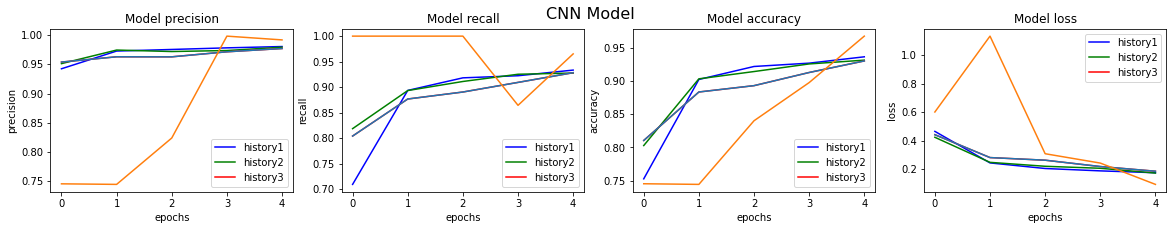

In [16]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

colors = ['b', 'g', 'r']
labels = ['history1', 'history2', 'history3']
histories = [history1, history2, history3]

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    for j, history in enumerate(histories):
        ax[i].plot(history.history[met], label=labels[j], color=colors[j])
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend()
fig.suptitle('CNN Model', fontsize=20)


Text(0.5, 0.98, 'CNN Model')

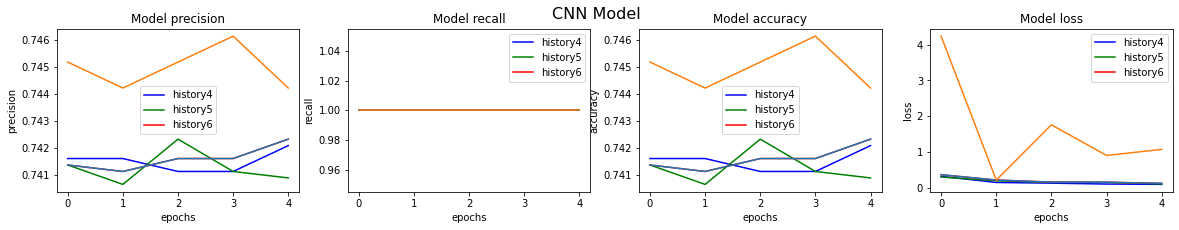

In [17]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

colors = ['b', 'g', 'r']
labels = ['history4', 'history5', 'history6']
histories = [history4, history5, history6]

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    for j, history in enumerate(histories):
        ax[i].plot(history.history[met], label=labels[j], color=colors[j])
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend()
fig.suptitle('CNN Model', fontsize=20)
    

In [18]:
loss, accuracy, precision, recall = model1.evaluate(test_ds)
print(f'CNN model1 \nLoss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

loss, accuracy, precision, recall = model2.evaluate(test_ds)
print(f'CNN model2 \nLoss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

loss, accuracy, precision, recall = model3.evaluate(test_ds)
print(f'CNN model3 \nLoss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 119ms/step - loss: 0.7404 - accuracy: 0.7452 - precision: 0.7112 - recall: 0.9974
CNN model1 
Loss: 0.7403676509857178,
Accuracy: 0.745192289352417,
Precision: 0.7111517190933228,
Recall: 0.9974358677864075
39/39 [==============================] - 5s 118ms/step - loss: 0.3949 - accuracy: 0.8413 - precision: 0.8575 - recall: 0.8949
CNN model2 
Loss: 0.39486876130104065,
Accuracy: 0.8413461446762085,
Precision: 0.8574938774108887,
Recall: 0.8948717713356018
39/39 [==============================] - 4s 109ms/step - loss: 0.4089 - accuracy: 0.8269 - precision: 0.7925 - recall: 0.9795
CNN model3 
Loss: 0.40887075662612915,
Accuracy: 0.8269230723381042,
Precision: 0.7925311326980591,
Recall: 0.9794871807098389


In [19]:
loss, accuracy, precision, recall = model4.evaluate(test_ds)
print(f'Resnet model1 \nLoss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

loss, accuracy, precision, recall = model5.evaluate(test_ds)
print(f'Resnet model2 \nLoss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

loss, accuracy, precision, recall = model6.evaluate(test_ds)
print(f'Resnet model3 \nLoss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 119ms/step - loss: 0.5565 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Resnet model1 
Loss: 0.5564597845077515,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0
39/39 [==============================] - 5s 114ms/step - loss: 0.3656 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Resnet model2 
Loss: 0.3656352162361145,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0
39/39 [==============================] - 5s 129ms/step - loss: 0.8467 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Resnet model3 
Loss: 0.8467105031013489,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0
